In [54]:
# load the ES_part_x files up to number 11 into df_es
import numpy as np
import pandas as pd
df_es = pd.DataFrame()

for i in range(1, 12):
    file_name = f'NE_part_{i}.csv'
    try:
        df_part = pd.read_csv(file_name)
        df_es = pd.concat([df_es, df_part], ignore_index=True)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")


# set Date column to datetime
df_es['Date'] = pd.to_datetime(df_es['Date'], errors='coerce')

# set Date as index and combine date with Time column so that it is a datetime index
df_es['DateTime'] = pd.to_datetime(df_es['Date'].astype(str) + ' ' + df_es['Time'], errors='coerce')
df_es.set_index('DateTime', inplace=True)
# drop the original Date and Time columns
df_es.drop(columns=['Date', 'Time'], inplace=True)
# sort the index
df_es.sort_index(inplace=True)


# Surprise Dataframe
# Load the Surprise dataset
df_surprise = pd.read_csv('JP_economic_releases_events.csv')

df_surprise.drop(columns=['S', 'Month', 'Surv(A)', 'Surv(H)', 'Surv(L)', 'Flag', 'Country/Region', 'Day', 'C', 'Category','Subcategory', 'Period', 'Actual'], inplace=True)
# Drop rows where surprise is NaN or -- (indicating no surprise)
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != '--']
# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]
# Change surprise column to numeric, coercing errors
df_surprise['Surprise'] = pd.to_numeric(df_surprise['Surprise'], errors='coerce')

# Drop rows where Time is NaN
df_surprise.dropna(subset=['Time'], inplace=True)

# Convert Unnamed: 0 column to datetime
df_surprise['Unnamed: 0'] = pd.to_datetime(df_surprise['Unnamed: 0'], errors='coerce')
# Combine datetime column with Time column and set as index
df_surprise['DateTime'] = pd.to_datetime(df_surprise['Unnamed: 0'].astype(str) + ' ' + df_surprise['Time'], errors='coerce')
df_surprise.set_index('DateTime', inplace=True)
# Drop the original Unnamed: 0 and Time columns
df_surprise.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
# Sort the index
df_surprise.sort_index(inplace=True)

# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]

# Wincorsizing to get results between 0.5% and 99.5% percentile for Surprise values

lower_bound = df_surprise['Surprise'].quantile(0.005)
upper_bound = df_surprise['Surprise'].quantile(0.995)

df_surprise = df_surprise[(df_surprise['Surprise'] >= lower_bound) & (df_surprise['Surprise'] <= upper_bound)]


# Combining the 2 dataframes on the index
# outer join the two DataFrames on the index
df_combined = pd.merge(df_es, df_surprise, left_index=True, right_index=True, how='outer', suffixes=('_es', '_surprise'))

# remove all rows with NaN values in Open Close / Volume - Do not take out volume, can be 0 (not necessarily a mistake)
df_combined.dropna(subset=['Open', 'Close'], inplace=True)

# Adding a column called 'Volume_L1' which is the Volume shifted by 1 day - which is the volume of the previous minute matched up with the current minute
df_combined['Volume_L1'] = df_combined['Volume'].shift(1)

# Now we create the technical explanatory variables based on literature

def create_technical_features(df):
    """
    Creates all technical features for a dataframe containing price/volume data
    and three return columns (Return, Return_half, Return_double)
    """
    # 1. Original Features
    df_combined['Volume'] = df_combined['Volume']
    df_combined['Price'] = df_combined['Open']

    # 2. Simple Moving Averages (now includes all required windows)
    ma_windows = [5, 10, 15, 20, 50, 100, 200]  # Added missing windows for crossovers
    for window in ma_windows:
        df[f'SMA{window}'] = df['Close'].rolling(window).mean() 

    # 3. Moving Average Crossovers (now all SMAs exist)
    for window in [5, 10, 15, 20, 50, 100, 200]:
        # No more need for existence check since we created all SMAs
        df[f'SMA{window}Cross'] = (df['Close'] > df[f'SMA{window}']).astype(int) # 1 for above SMA, 0 for below

    # 4. Consecutive Price Trends
    trend_periods = [10, 15, 50]
    for period in trend_periods:
        df[f'UpDown{period}'] = np.sign(df['Close'].pct_change(period)) # 1 for up, -1 for down, NaN for no change

    # Ensure we keep the original return columns
    return_cols = ['Return', 'Return_half', 'Return_double']
    for col in return_cols:
        if col in df.columns:
            df[col] = df[col]  # Maintain existing returns

    return df

# Example usage:
# df_combined must contain: 'volume', 'close' columns plus the 3 return columns
df_combined = create_technical_features(df_combined)

import datetime
import pandas as pd
import pandas_datareader as pdr

# --- 1. Set Start and End Dates, matches up with last date of df_combined ---
start = df_combined.index.min() # Get the first date from df_combined
end = df_combined.index.max()  # Get the last date from df_combined

# print start and end
print(f"Start Date: {start}, End Date: {end}")

# --- 2. Get GDP Growth Data ---
gdp_gr = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end)

# Create gdp_gr_ml dataframe
gdp_gr_ml = gdp_gr.reset_index()
gdp_gr_ml.rename(columns={'A191RL1Q225SBEA': 'gdp_gr'}, inplace=True)
gdp_gr_ml['DateTime'] = pd.to_datetime(gdp_gr_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
gdp_gr_ml = gdp_gr_ml[['DateTime', 'gdp_gr']]

# for both datasets set 'DateTime' as index and then drop columns
gdp_gr_ml.set_index('DateTime', inplace=True)

# make sure sorted on datetime
gdp_gr_ml.sort_index(inplace=True)


# Combine with Final Dataframe

# Merge the last known GDP growth merge on index
df_combined = pd.merge_asof(
    df_combined,
    gdp_gr_ml,
    on='DateTime',
    direction='backward'
)

# Rename the merged columns to last_gdp_gr and last_vix
df_combined = df_combined.rename(columns={
    'gdp_gr': 'last_gdp_gr'
})

# Set DateTime column as Index
df_combined.set_index('DateTime', inplace=True)

def calculate_daily_realized_volatility(df, freq='5min', close_col='Close'):
    """
    Calculates the daily realized volatility (non-annualized) from intraday data.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a close price column.
        freq (str): The sampling frequency (e.g., '1min', '5min', '15min').
        close_col (str): The name of the close price column.

    Returns:
        pd.Series: A Series of daily (non-annualized) realized volatility.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("The DataFrame index must be a DatetimeIndex.")
        
    # Resample the close price to the desired frequency
    df_resampled = df[close_col].resample(freq).last()

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Group by day and calculate the sum of squared returns (realized variance)
    realized_variance_daily = (log_returns**2).resample('D').sum()
    
    # Filter out days with no trading activity
    realized_variance_daily = realized_variance_daily[realized_variance_daily > 0]
    
    # Calculate daily volatility (standard deviation), which is the square root of variance.
    # The result is NOT annualized, making it suitable for ML models.
    realized_volatility_daily = np.sqrt(realized_variance_daily)
    
    return realized_volatility_daily.dropna()


def analyze_and_add_volatility(df_combined):
    """
    Calculates daily realized volatility and adds it as a new column
    to the provided DataFrame in-place.

    Args:
        df_combined (pd.DataFrame): Your DataFrame with minute-level data.
                                    It must have a DatetimeIndex and a 'Close' column.
                                    This function modifies the DataFrame in-place.
    
    Returns:
        pd.DataFrame: The modified DataFrame with the new 'daily realized volatility' column.
    """
    # --- 1. Calculate Volatility ---
    # We use a 5-minute interval as a standard practice to balance capturing
    # volatility information and reducing market microstructure noise.
    # You can change this value if needed.
    sampling_interval = '5min'
    print(f"Calculating daily realized volatility using a '{sampling_interval}' sampling interval...")
    
    daily_volatility = calculate_daily_realized_volatility(
        df_combined, 
        freq=sampling_interval, 
        close_col='Close' # Using 'Close' with a capital C
    )

    # --- 2. Add Volatility Column to DataFrame ---
    # Map the calculated daily volatility back to the original minute-level DataFrame.
    # Each row will have the realized volatility value for its corresponding day.
    print("Adding 'daily realized volatility' column to the DataFrame...")
    # Normalize index to match the daily frequency of the volatility series
    df_combined['daily realized volatility'] = df_combined.index.normalize().map(daily_volatility)
    
    print("\n'daily realized volatility' column has been added successfully.")
        
    return df_combined


# --- HOW TO USE ---
if __name__ == '__main__':
    # 1. Make sure your DataFrame `df_combined` is loaded and available.
    #    It must have a DatetimeIndex and columns named:
    #    'open', 'high', 'low', 'Close', 'tick_count', 'volume'.
    #
    # Example of loading your data:
    # df_combined = pd.read_csv('path/to/your/futures_data.csv', 
    #                           parse_dates=['timestamp_column'], 
    #                           index_col='timestamp_column')

    # 2. Once `df_combined` is loaded, uncomment and run the following line:
    # df_combined_with_vol = analyze_and_add_volatility(df_combined)
    
    print("Script is ready. Please load your 'df_combined' DataFrame and call 'analyze_and_add_volatility(df_combined)' to start.")
    
    # For demonstration, if a variable named `df_combined` exists, we'll run the analysis.
    if 'df_combined' in locals() or 'df_combined' in globals():
        print("\n'df_combined' detected. Running analysis...")
        df_combined_with_vol = analyze_and_add_volatility(df_combined)

Start Date: 2008-02-01 09:01:00, End Date: 2024-12-19 15:46:00
Script is ready. Please load your 'df_combined' DataFrame and call 'analyze_and_add_volatility(df_combined)' to start.

'df_combined' detected. Running analysis...
Calculating daily realized volatility using a '5min' sampling interval...
Adding 'daily realized volatility' column to the DataFrame...

'daily realized volatility' column has been added successfully.


In [55]:
import pandas as pd
import numpy as np

# --- Assumed DataFrame ---
# This code assumes you have a pre-existing DataFrame named 'df_combined'
# with a 'Close' price column.

# --- Configuration ---
# Base holding period. For data in minutes, this represents 20 minutes.
holding_period = 20

# Define the horizons for calculation.
horizons = ['', '_half', '_double']

# --- Main Loop to Generate Columns ---
for h in horizons:
    # 1. Determine the calculation period and descriptive minute value
    if h == '_half':
        period = holding_period // 2
        minutes = holding_period // 2
    elif h == '_double':
        period = holding_period * 2
        minutes = holding_period * 2
    else:  # h == ''
        period = holding_period
        minutes = holding_period

    # 2. Define the new, descriptive column names
    return_col_name = f'Forward Return ({minutes} min)'
    target_col_name = f'Target Signal ({minutes} min)'

    # 3. Calculate the base forward return using the 'Close' price.
    # This shifts the future 'Close' price to the current row to represent
    # the potential return from a trade initiated now.
    future_price = df_combined['Close'].shift(-period)
    current_price = df_combined['Close']

    # Calculate return for a long position (buy low, sell high)
    long_return = (future_price / current_price) - 1

    # Calculate return for a short position (sell high, buy low)
    short_return = (current_price / future_price) - 1

    # 4. Create the Forward Return column.
    # This represents the gross percentage return for a long position.
    df_combined[return_col_name] = long_return

    # 5. Create the categorical "Target Signal" column.
    # The target is based on whether a trade is profitable, ignoring costs.
    # 0 = Hold, 1 = Buy, 2 = Sell

    # "Buy" signal is generated if the long return is positive.
    cond_buy = long_return > 0

    # "Sell" signal is generated if the short return is positive.
    cond_sell = short_return > 0

    # Apply the signals to the target column
    df_combined[target_col_name] = 0  # Default to Hold
    df_combined.loc[cond_buy, target_col_name] = 1
    df_combined.loc[cond_sell, target_col_name] = 2

# The 'df_combined' DataFrame is now updated with the six new columns,
# calculated without considering transaction costs.

In [56]:
import pandas as pd
import numpy as np

# This script assumes 'df_combined' is an existing DataFrame with a DateTimeIndex
# and columns 'Ticker' and 'Surprise'.

# --- 1. Filter for Event Rows Only ---
# First, create a smaller dataframe that only contains rows where a surprise occurred.
# This makes the pivot operation much more efficient.
print("Step 1: Filtering for rows with surprise events...")
surprise_events_only = df_combined[df_combined['Surprise'].notna()].copy()
print(f"Found {len(surprise_events_only)} rows with surprise events to pivot.")


# --- 2. Pivot the Filtered Data ---
# Now, we pivot this smaller dataframe.
# - The index of the new dataframe will be the original DateTimeIndex.
# - New columns will be created from the unique values in the 'Ticker' column.
# - The values for these new columns will be taken from the 'Surprise' column.
# - `fill_value=0` is critical: it ensures that for any given event row, all ticker
#   columns that were NOT part of that event are filled with 0.
print("\nStep 2: Pivoting the data...")
event_df = surprise_events_only.pivot_table(
    index=surprise_events_only.index,
    columns='Ticker',
    values='Surprise',
    fill_value=0
)

# Optional: Add a suffix to the new column names for clarity
event_df = event_df.add_suffix('_Surprise')
print("Pivoting complete.")


# --- 3. Verify the Result ---
print("\n--- Event DataFrame Sample ---")
print(event_df.head())

print(f"\nShape of the new event DataFrame: {event_df.shape}")
print(f"Number of rows matches the number of events, and number of columns matches unique tickers.")

# The `event_df` is now ready. It only contains rows from event times,
# and each ticker has its own column filled with either the surprise value or 0.


Step 1: Filtering for rows with surprise events...
Found 3932 rows with surprise events to pivot.

Step 2: Pivoting the data...
Pivoting complete.

--- Event DataFrame Sample ---
Ticker               BOJDPBAL Index_Surprise  BOJDTR Index_Surprise  \
DateTime                                                              
2008-02-08 14:00:00                      0.0                    0.0   
2008-02-26 14:00:00                      0.0                    0.0   
2008-02-29 14:00:00                      0.0                    0.0   
2008-03-03 10:30:00                      0.0                    0.0   
2008-03-12 14:00:00                      0.0                    0.0   

Ticker               BOJTARMB Index_Surprise  JBSIBCLA Index_Surprise  \
DateTime                                                                
2008-02-08 14:00:00                      0.0                      0.0   
2008-02-26 14:00:00                      0.0                      0.0   
2008-02-29 14:00:00            

In [57]:
# Step 2: Selecting feature and target columns from df_combined
# all columns with 'SMA' at start or 'UpDown' and 'Last_GDP_GR' and 'Last_VIX' at the end and
feature_columns = [col for col in df_combined.columns if col.startswith('SMA') or col.startswith('UpDown') or col in ['last_gdp_gr', 'daily realized volatility']]
columns_to_join = feature_columns

# also include the 'R' and 'Volume_L1' and 'Surprise' columns
columns_to_join += ['R', 'Volume_L1', 'Surprise', 'Std Dev']

# also include the return columns
list = [
    'Forward Return (20 min)',
    'Target Signal (20 min)',
    'Forward Return (10 min)',
    'Target Signal (10 min)',
    'Forward Return (40 min)',
    'Target Signal (40 min)'
]

columns_to_join += list

features_and_target_from_combined = df_combined[columns_to_join]

ml_df = event_df.join(features_and_target_from_combined, how='inner')

# Clean up any potential NaNs that might arise from the join, just in case.
ml_df.fillna(0, inplace=True)

print("Join complete.")


# --- 4. Verify the Final DataFrame ---
print("\n--- Final ML-Ready DataFrame ---")
print(ml_df.head())

print(f"\nShape of the final DataFrame: {ml_df.shape}")
print(f"The number of rows ({ml_df.shape[0]}) should match the number of surprise events.")
print("\nFinal columns available for the model:")
print(ml_df.columns.tolist())

# The `ml_df` DataFrame is now complete and ready to be split into X (all columns except Target)
# and y (the Target column) to be fed into your XGBoost model.

Join complete.

--- Final ML-Ready DataFrame ---
                     BOJDPBAL Index_Surprise  BOJDTR Index_Surprise  \
DateTime                                                              
2008-02-08 14:00:00                      0.0                    0.0   
2008-02-08 14:00:00                      0.0                    0.0   
2008-02-26 14:00:00                      0.0                    0.0   
2008-02-29 14:00:00                      0.0                    0.0   
2008-02-29 14:00:00                      0.0                    0.0   

                     BOJTARMB Index_Surprise  JBSIBCLA Index_Surprise  \
DateTime                                                                
2008-02-08 14:00:00                      0.0                      0.0   
2008-02-08 14:00:00                      0.0                      0.0   
2008-02-26 14:00:00                      0.0                      0.0   
2008-02-29 14:00:00                      0.0                      0.0   
2008-02-29 14:0

In [58]:
# rename ml_df to df_ml
df_ml = ml_df

# adjust df_ml so that index, DateTime, become a single column
df_ml.reset_index(inplace=True)

df_ml

,DateTime,BOJDPBAL Index_Surprise,BOJDTR Index_Surprise,BOJTARMB Index_Surprise,JBSIBCLA Index_Surprise,JBSIBCLM Index_Surprise,JCOMACF Index_Surprise,JCOMHCF Index_Surprise,JCOMSHCF Index_Surprise,JCPNEFFE Index_Surprise,...,R,Volume_L1,Surprise,Std Dev,Forward Return (20 min),Target Signal (20 min),Forward Return (10 min),Target Signal (10 min),Forward Return (40 min),Target Signal (40 min)
0,2008-02-08 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,67.0,-5.48,0.68,0.000000,0,-0.001506,2,0.000000,0
1,2008-02-08 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,32.0,-0.67,0.45,-0.000803,2,-0.002309,2,-0.001506,2
2,2008-02-26 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,472.0,3.18,0.41,-0.002828,2,-0.003582,2,-0.002828,2
3,2008-02-29 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.3656,314.0,2.25,2.93,-0.000770,2,-0.001444,2,-0.003658,2
4,2008-02-29 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.1613,164.0,1.76,0.04,-0.000770,2,-0.001444,2,-0.002984,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,2024-07-01 08:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,83.8710,82.0,-1.05,2.62,-0.001236,2,-0.001740,2,-0.000731,2
3928,2024-07-01 08:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.5806,82.0,-0.22,2.24,-0.000731,2,-0.001740,2,-0.000731,2
3929,2024-07-01 08:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.5054,82.0,-0.41,2.41,-0.000479,2,-0.001992,2,-0.000252,2
3930,2024-07-05 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.2151,50.0,0.33,0.46,-0.000246,2,0.000000,0,-0.000715,2


DataFrame 'df_ml' found. Running the Logistic Regression model...
--- Running Isolated Logistic Regression Model with Integrated Metrics ---
Environment and seeds have been reset for a clean run. ✅
Feature Columns: ['BOJDPBAL Index_Surprise', 'BOJDTR Index_Surprise', 'BOJTARMB Index_Surprise', 'JBSIBCLA Index_Surprise', 'JBSIBCLM Index_Surprise', 'JCOMACF Index_Surprise', 'JCOMHCF Index_Surprise', 'JCOMSHCF Index_Surprise', 'JCPNEFFE Index_Surprise', 'JFYFCPI2 Index_Surprise', 'JFYFCPIC Index_Surprise', 'JGDFDEFY Index_Surprise', 'JGDOQOQ Index_Surprise', 'JGDPAGDP Index_Surprise', 'JGDPCIQ Index_Surprise', 'JGDPCNEX Index_Surprise', 'JGDPCPIN Index_Surprise', 'JGDPPCQ Index_Surprise', 'JGDPQGDP Index_Surprise', 'JMNSM2Y Index_Surprise', 'JMNSM3Y Index_Surprise', 'JNBLBYOY Index_Surprise', 'JNBLENDA Index_Surprise', 'JNBPAB Index_Surprise', 'JNBPABA Index_Surprise', 'JNBPTRD Index_Surprise', 'JNCAPMOM Index_Surprise', 'JNCICCOI Index_Surprise', 'JNCICLEI Index_Surprise', 'JNCRPYOY Inde

c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\sklearn\linear_model\_logisti

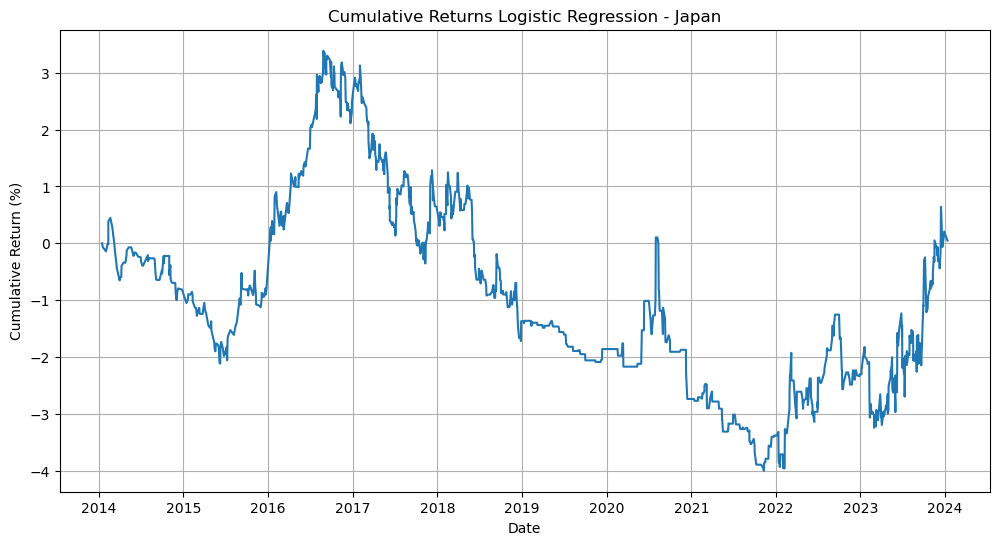


Final Cumulative Compounded Return: 0.05%
Overall Test Accuracy : 32.87%
Overall Precision: 33.98%
Overall Recall: 35.66%
Overall F1 Score: 31.88%
Overall ROC AUC: 52.69%

Average Fold Test Return : 0.00100%
Standard Deviation of All Test Returns (Aggregated Daily): 0.15396%
Minimum Return (Aggregated Daily): -0.60309%

--- Optimization Results ---

Optimal Horizon Counts:
(20 min)    6
(10 min)    2
(40 min)    2
Name: count, dtype: int64

Optimal Threshold Counts:
0.55    4
0.00    4
0.85    2
Name: count, dtype: int64

Test Set Position Counts (After Thresholding):
Neutral (0): 1222
Long (1): 1015
Short (2): 1033

Final Model Performance Evaluation

Confusion Matrix:
                    Pred Neutral (0)  Pred Long (1)  Pred Short (2)
Actual Neutral (0)               195            102             137
Actual Long (1)                  479            462             478
Actual Short (2)                 548            451             418

Classification Report:
              precision 

In [59]:
import os
import warnings
import random
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

def set_all_seeds(seed_value=42):
    """
    Sets all necessary random seeds and environment variables for full
    reproducibility. This function acts as a complete reset for the
    computational environment.
    """
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['OPENBLAS_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
    os.environ['NUMEXPR_NUM_THREADS'] = '1'
    random.seed(seed_value)
    np.random.seed(seed_value)
    # Suppress specified warnings for cleaner output
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=DeprecationWarning)

def run_logistic_regression_with_metrics(df_ml):
    """
    Runs the entire Logistic Regression walk-forward validation in a fully
    isolated environment and prints all results, including the confusion
    matrix and classification report, at the end.
    
    Args:
        df_ml (pd.DataFrame): The pre-loaded DataFrame containing features and targets.
    """
    # -------------------------------------------------------------------
    # 1. HARD RESET FOR FULL REPRODUCIBILITY
    # This is the critical fix to ensure consistent results.
    # -------------------------------------------------------------------
    set_all_seeds(42)
    print("--- Running Isolated Logistic Regression Model with Integrated Metrics ---")
    print("Environment and seeds have been reset for a clean run. ✅")

    # --- Feature Columns ---
    feature_cols = df_ml.columns[:-6].tolist()
    if 'DateTime' in feature_cols:
        feature_cols.remove('DateTime')
    print("Feature Columns:", feature_cols)
    print("Number of Features:", len(feature_cols))

    # --- Configuration ---
    transaction_cost = 0.000025
    total_cost = 2 * transaction_cost
    horizons = [' (20 min)', ' (10 min)', ' (40 min)']
    threshold_options = [0.0, 0.55, 0.65, 0.75, 0.85]

    # --- Data Prep ---
    df_ml = df_ml.dropna(subset=['Surprise']).sort_values('DateTime')
    min_date, max_date = df_ml['DateTime'].min(), df_ml['DateTime'].max()
    
    # --- Calculate Initial Training Window ---
    initial_train_duration = (max_date - min_date) * 0.3
    train_start_date = min_date
    train_end_date = min_date + initial_train_duration

    # --- Tracking containers ---
    all_test_returns, all_dates, all_test_preds, all_test_truths, all_test_probas = [], [], [], [], []
    fold_mean_returns, best_horizons_list, best_thresholds_list = [], [], []

    def calculate_grouped_returns(df_group, horizon, stop_loss=None):
        active_trades = df_group[df_group['pred'] != 0]
        if active_trades.empty: return 0.0
        longs = active_trades[active_trades['pred'] == 1].copy().reset_index(drop=True)
        shorts = active_trades[active_trades['pred'] == 2].copy().reset_index(drop=True)
        total_confidence = longs['proba'].sum() + shorts['proba'].sum()
        if total_confidence == 0: return 0.0
        num_trades = len(longs) + len(shorts)
        total_costs = total_cost * num_trades
        long_returns, short_returns = 0.0, 0.0
        if not longs.empty:
            long_weights = longs['proba'] / total_confidence
            for idx in longs.index:
                raw_return = longs.loc[idx, f'Forward Return{horizon}']
                capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
                long_returns += capped_raw * long_weights.loc[idx]
        if not shorts.empty:
            short_weights = shorts['proba'] / total_confidence
            for idx in shorts.index:
                raw_return = -shorts.loc[idx, f'Forward Return{horizon}']
                capped_raw = max(stop_loss, raw_return) if stop_loss is not None else raw_return
                short_returns += capped_raw * short_weights.loc[idx]
        return (long_returns + short_returns) - total_costs

    # --- Main Loop ---
    while True:
        val_start_date = train_end_date + pd.DateOffset(days=1)
        val_end_date = val_start_date + pd.DateOffset(years=1)
        test_start_date = val_end_date + pd.DateOffset(days=1)
        test_end_date = test_start_date + pd.DateOffset(years=1)
        if val_end_date > max_date or test_end_date > max_date: break
        
        train_mask = (df_ml['DateTime'] >= train_start_date) & (df_ml['DateTime'] <= train_end_date)
        val_mask = (df_ml['DateTime'] >= val_start_date) & (df_ml['DateTime'] <= val_end_date)
        test_mask = (df_ml['DateTime'] >= test_start_date) & (df_ml['DateTime'] <= test_end_date)
        train_data, val_data, test_data = df_ml[train_mask], df_ml[val_mask], df_ml[test_mask]

        if val_data.empty or test_data.empty or train_data.empty:
            print(f"Skipping period starting {val_start_date.date()} (no data)")
            train_end_date += pd.DateOffset(years=1)
            continue

        best_horizon, best_model, best_stop_loss, best_scaler, best_threshold = None, None, None, None, None
        best_val_return = -np.inf

        for horizon in horizons:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(train_data[feature_cols])
            X_val = scaler.transform(val_data[feature_cols])
            y_train = train_data[f'Target Signal{horizon}']
            
            model = LogisticRegression(
                multi_class='multinomial',
                solver='saga',
                max_iter=1000, # Increased for convergence
                random_state=42, # Ensures model's internal randomness is the same
                n_jobs=-1 # Use all available cores
            )
            model.fit(X_train, y_train)

            class_map = {cls: idx for idx, cls in enumerate(model.classes_)}

            for threshold in threshold_options:
                val_preds_original = model.predict(X_val)
                val_probas = model.predict_proba(X_val)
                max_probas = np.max(val_probas, axis=1)
                val_preds_filtered = np.where(max_probas >= threshold, val_preds_original, 0)
                
                val_trade_df = pd.DataFrame({
                    'DateTime': val_data['DateTime'], 'pred': val_preds_filtered,
                    'proba': [p[class_map.get(pred, 0)] for pred, p in zip(val_preds_original, val_probas)],
                    f'Forward Return{horizon}': val_data[f'Forward Return{horizon}'].values
                })

                train_preds = model.predict(X_train)
                individual_train_returns = []
                train_returns_series = train_data[f'Forward Return{horizon}']
                for i, pred in enumerate(train_preds):
                    if pred == 1: individual_train_returns.append(train_returns_series.iloc[i])
                    elif pred == 2: individual_train_returns.append(-train_returns_series.iloc[i])
                stop_loss_train = np.percentile(individual_train_returns, 5) if individual_train_returns else None

                if stop_loss_train is not None:
                    val_returns = val_trade_df.groupby('DateTime').apply(lambda x: calculate_grouped_returns(x, horizon, stop_loss_train)).values
                    total_val_return = (1 + val_returns).prod() - 1
                    if total_val_return > best_val_return:
                        best_val_return = total_val_return
                        best_horizon, best_model, best_threshold, best_scaler = horizon, model, threshold, scaler
                        individual_val_returns = []
                        val_returns_series = val_data[f'Forward Return{horizon}']
                        val_preds_for_sl = model.predict(X_val)
                        for i, pred in enumerate(val_preds_for_sl):
                            if pred == 1: individual_val_returns.append(val_returns_series.iloc[i])
                            elif pred == 2: individual_val_returns.append(-val_returns_series.iloc[i])
                        best_stop_loss = np.percentile(individual_val_returns, 5) if individual_val_returns else None

        if best_model and best_stop_loss is not None and best_threshold is not None:
            X_test = best_scaler.transform(test_data[feature_cols])
            test_preds_original = best_model.predict(X_test)
            test_probas = best_model.predict_proba(X_test)
            y_test = test_data[f'Target Signal{best_horizon}'].values
            max_probas_test = np.max(test_probas, axis=1)
            test_preds_filtered = np.where(max_probas_test >= best_threshold, test_preds_original, 0)
            
            test_class_map = {cls: idx for idx, cls in enumerate(best_model.classes_)}
            test_trade_df = pd.DataFrame({
                'DateTime': test_data['DateTime'], 'pred': test_preds_filtered,
                'proba': [p[test_class_map.get(pred, 0)] for pred, p in zip(test_preds_original, test_probas)],
                f'Forward Return{best_horizon}': test_data[f'Forward Return{best_horizon}'].values
            })
            grouped_returns = test_trade_df.groupby('DateTime').apply(lambda x: calculate_grouped_returns(x, best_horizon, best_stop_loss)).values
            
            all_test_returns.extend(grouped_returns)
            all_dates.extend(test_trade_df['DateTime'].unique().tolist())
            all_test_preds.extend(test_preds_filtered)
            all_test_truths.extend(y_test)
            all_test_probas.append(test_probas)
            fold_mean_returns.append(np.mean(grouped_returns))
            best_horizons_list.append(best_horizon or 'standard')
            best_thresholds_list.append(best_threshold)

        train_end_date += pd.DateOffset(years=1)

    # --- Results ---
    if all_test_returns:
        cumulative_returns = (1 + np.array(all_test_returns)).cumprod() - 1
        std_dev_individual = np.std(all_test_returns) * 100
        min_return = np.nanmin(all_test_returns) * 100 if all_test_returns else 0.0
        plt.figure(figsize=(12, 6))
        sorted_dates, sorted_returns = zip(*sorted(zip(all_dates, cumulative_returns)))
        plt.plot(sorted_dates, [r * 100 for r in sorted_returns])
        plt.title('Cumulative Returns Logistic Regression - Japan'); plt.xlabel('Date'); plt.ylabel('Cumulative Return (%)'); plt.grid(True); plt.show()

        print(f"\nFinal Cumulative Compounded Return: {cumulative_returns[-1]*100:.2f}%")
        print(f"Overall Test Accuracy : {accuracy_score(all_test_truths, all_test_preds)*100:.2f}%")
        print(f"Overall Precision: {precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
        print(f"Overall Recall: {recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
        print(f"Overall F1 Score: {f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.2f}%")
        
        roc_auc_value = "N/A"
        if len(np.unique(all_test_truths)) > 1 and len(all_test_probas) > 0:
            try:
                stacked_probas = np.vstack(all_test_probas)
                roc_auc = roc_auc_score(all_test_truths, stacked_probas, multi_class='ovo', average='macro')
                roc_auc_value = f"{roc_auc*100:.2f}"
                print(f"Overall ROC AUC: {roc_auc_value}%")
            except ValueError as e:
                print(f"Overall ROC AUC: Could not be calculated. Error: {e}")
        else:
            print("Overall ROC AUC: Not enough data for calculation.")
        
        print(f"\nAverage Fold Test Return : {np.mean(fold_mean_returns)*100:.5f}%")
        print(f"Standard Deviation of All Test Returns (Aggregated Daily): {std_dev_individual:.5f}%")
        print(f"Minimum Return (Aggregated Daily): {min_return:.5f}%")
        
        print("\n--- Optimization Results ---")
        print("\nOptimal Horizon Counts:"); print(pd.Series(best_horizons_list).value_counts())
        print("\nOptimal Threshold Counts:"); print(pd.Series(best_thresholds_list).value_counts())
        
        counts = pd.Series(all_test_preds).value_counts().sort_index()
        print("\nTest Set Position Counts (After Thresholding):")
        print(f"Neutral (0): {counts.get(0, 0)}")
        print(f"Long (1): {counts.get(1, 0)}")
        print(f"Short (2): {counts.get(2, 0)}")

        # ===================================================================
        # INTEGRATED CONFUSION MATRIX AND CLASSIFICATION REPORT
        # ===================================================================
        print("\n" + "="*50)
        print("Final Model Performance Evaluation")
        print("="*50)

        print("\nConfusion Matrix:")
        cm = confusion_matrix(all_test_truths, all_test_preds)
        cm_df = pd.DataFrame(cm,
                             index=['Actual Neutral (0)', 'Actual Long (1)', 'Actual Short (2)'],
                             columns=['Pred Neutral (0)', 'Pred Long (1)', 'Pred Short (2)'])
        print(cm_df)

        print("\nClassification Report:")
        print(classification_report(all_test_truths, all_test_preds,
                                    target_names=['Neutral (0)', 'Long (1)', 'Short (2)'],
                                    zero_division=0))
        print("="*50)
        # ===================================================================

        # --- Save results to Excel ---
        output_filename = 'thesis_model_comparison5.xlsx'
        model_name = 'Logistic Regression'
        results_data = {
            'CCR (%)': f"{cumulative_returns[-1]*100:.3f}", 'Return Volatility (%)': f"{std_dev_individual:.3f}",
            'Accuracy (%)': f"{accuracy_score(all_test_truths, all_test_preds)*100:.3f}",
            'Precision (%)': f"{precision_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.3f}",
            'Recall (%)': f"{recall_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.3f}",
            'F1 Score (%)': f"{f1_score(all_test_truths, all_test_preds, average='macro', zero_division=0)*100:.3f}",
            'ROC AUC (%)': roc_auc_value.replace('%', ''), 'Minimum Return (%)': f"{min_return:.3f}",
            'Long count': counts.get(1, 0), 'Short count': counts.get(2, 0),
            'No trade count': counts.get(0, 0)
        }
        new_results_df = pd.DataFrame.from_dict(results_data, orient='index', columns=[model_name])
        new_results_df.index.name = 'Variable'

        try:
            existing_df = pd.read_excel(output_filename, index_col='Variable')
            existing_df[model_name] = new_results_df[model_name]
            existing_df.to_excel(output_filename)
            print(f"\nUpdated results for '{model_name}' in '{output_filename}'")
        except FileNotFoundError:
            new_results_df.to_excel(output_filename)
            print(f"\nCreated '{output_filename}' with results for '{model_name}'")
        except Exception as e:
            print(f"\nAn error occurred while saving to Excel: {e}")
            
    else:
        print("No valid test periods found")

# ===================================================================
# HOW TO RUN THIS SCRIPT
#
# To run this model, simply execute this cell in your notebook after
# the DataFrame `df_ml` has been created and loaded.
# ===================================================================

if 'df_ml' in locals() or 'df_ml' in globals():
    print("DataFrame 'df_ml' found. Running the Logistic Regression model...")
    run_logistic_regression_with_metrics(df_ml)
else:
    print("🚨 ERROR: DataFrame `df_ml` not found. 🚨")
    print("Please make sure you have loaded your data into a DataFrame named 'df_ml' before running this script.")

In [60]:
# From the ML model ran above, print the a list of 20 most important features
def print_top_20_features(model, feature_names):
    """
    Prints the top 20 most important features from a fitted model.
    
    Args:
        model: A fitted model with a `coef_` or `feature_importances_` attribute.
        feature_names: List of feature names corresponding to the model's input features.
    """
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        raise ValueError("Model does not have 'coef_' or 'feature_importances_' attribute.")
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    # Sort by importance and get the top 20 features
    top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
    
    print("\nTop 20 Features:")
    print(top_features)

# Example usage:
if 'best_model' in locals() or 'best_model' in globals():
    print_top_20_features(best_model, feature_cols)
else:
    print("No model found to extract feature importance. Please ensure a model is trained before calling this function.")

# if Feature column contains Index, change value to include everything up to the first underscore
def clean_feature_names(feature_names):
    """
    Cleans feature names by removing everything after the first underscore.
    
    Args:
        feature_names (list): List of feature names to clean.
        
    Returns:
        list: Cleaned feature names.
    """
    cleaned_names = []
    for name in feature_names:
        if '_' in name:
            cleaned_name = name.split('_')[0]  # Take everything before the first underscore
        else:
            cleaned_name = name  # No underscore, keep the original name
        cleaned_names.append(cleaned_name)
    
    return cleaned_names

# Example usage:
if 'feature_cols' in locals() or 'feature_cols' in globals():
    cleaned_feature_names = clean_feature_names(feature_cols)
    print("\nCleaned Feature Names:")
    print(cleaned_feature_names)

# create dataframe for cleaned feature names and importance scores
def create_feature_importance_df(model, feature_names):
    """
    Creates a DataFrame of feature importance scores.
    
    Args:
        model: A fitted model with a `coef_` or `feature_importances_` attribute.
        feature_names: List of feature names corresponding to the model's input features.
        
    Returns:
        pd.DataFrame: DataFrame containing feature names and their importance scores.
    """
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        raise ValueError("Model does not have 'coef_' or 'feature_importances_' attribute.")
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })
    
    return feature_importance_df

# Example usage:
if 'best_model' in locals() or 'best_model' in globals():
    feature_importance_df = create_feature_importance_df(best_model, cleaned_feature_names)
    print("\nFeature Importance DataFrame:")
    print(feature_importance_df.sort_values(by='Importance', ascending=False).head(20))


Top 20 Features:
                      Feature  Importance
89  daily realized volatility    0.675596
86                   UpDown15    0.417662
12     JGDOQOQ Index_Surprise    0.304977
13    JGDPAGDP Index_Surprise    0.303311
35     JNIPYOY Index_Surprise    0.249654
59    JNVNYOYS Index_Surprise    0.248782
34     JNIPMOM Index_Surprise    0.241701
85                   UpDown10    0.226207
62    JPTFLMFG Index_Surprise    0.222668
44    JNRETMOM Index_Surprise    0.216802
87                   UpDown50    0.210275
14     JGDPCIQ Index_Surprise    0.203374
84                SMA200Cross    0.181939
63    JPTFLNMF Index_Surprise    0.174996
7     JCOMSHCF Index_Surprise    0.169303
28    JNCICLEI Index_Surprise    0.158236
82                 SMA50Cross    0.156314
33     JNHSYOY Index_Surprise    0.154750
48      JNTBAL Index_Surprise    0.140973
81                 SMA20Cross    0.139869

Cleaned Feature Names:
['BOJDPBAL Index', 'BOJDTR Index', 'BOJTARMB Index', 'JBSIBCLA Index', 'JBSI

In [61]:
# reset index for feature importance DataFrame
feature_importance_df.reset_index(drop=True, inplace=True)

print("\nFeature Importance DataFrame with Reset Index:")
print(feature_importance_df.sort_values(by='Importance', ascending=False).head(20))
print(feature_importance_df.columns.tolist())


Feature Importance DataFrame with Reset Index:
                      Feature  Importance
89  daily realized volatility    0.675596
86                   UpDown15    0.417662
12              JGDOQOQ Index    0.304977
13             JGDPAGDP Index    0.303311
35              JNIPYOY Index    0.249654
59             JNVNYOYS Index    0.248782
34              JNIPMOM Index    0.241701
85                   UpDown10    0.226207
62             JPTFLMFG Index    0.222668
44             JNRETMOM Index    0.216802
87                   UpDown50    0.210275
14              JGDPCIQ Index    0.203374
84                SMA200Cross    0.181939
63             JPTFLNMF Index    0.174996
7              JCOMSHCF Index    0.169303
28             JNCICLEI Index    0.158236
82                 SMA50Cross    0.156314
33              JNHSYOY Index    0.154750
48               JNTBAL Index    0.140973
81                 SMA20Cross    0.139869
['Feature', 'Importance']


In [73]:
# right join feature importance dataframe with surprise dataframe using Feature column from feature importance df and Ticker column from surprise df
# Ensure both DataFrames have the necessary columns
if 'Feature' not in feature_importance_df.columns or 'Ticker' not in df_surprise.columns:
    raise ValueError("Both DataFrames must contain 'Feature' and 'Ticker' columns.")

# Perform the right join
result_df = pd.merge(df_surprise, feature_importance_df, how='right', left_on='Ticker', right_on='Feature')
# drop duplicate Feature values'
result_df.drop_duplicates(subset='Feature', keep='first', inplace=True)
# Keep columns Feature Ticker Event and Importance
result_df = result_df[['Feature', 'Ticker', 'Event', 'Importance']]
# Sort on Importance high to low
result_df.sort_values(by='Importance', ascending=False, inplace=True)

print(result_df.head(20))

# if Event is NaN replace this with the Feature value for this row
result_df['Event'].fillna(result_df['Feature'], inplace=True)

# keep columns Event and Importance
result_df = result_df[['Event', 'Importance']]

                        Feature          Ticker                         Event  \
8348  daily realized volatility             NaN                           NaN   
8345                   UpDown15             NaN                           NaN   
429               JGDOQOQ Index   JGDOQOQ Index            GDP Nominal SA QoQ   
548              JGDPAGDP Index  JGDPAGDP Index         GDP Annualized SA QoQ   
3362              JNIPYOY Index   JNIPYOY Index     Industrial Production YoY   
7241             JNVNYOYS Index  JNVNYOYS Index          Capital Spending YoY   
3072              JNIPMOM Index   JNIPMOM Index     Industrial Production MoM   
8344                   UpDown10             NaN                           NaN   
7739             JPTFLMFG Index  JPTFLMFG Index      Tankan Large Mfg Outlook   
4966             JNRETMOM Index  JNRETMOM Index              Retail Sales MoM   
8346                   UpDown50             NaN                           NaN   
699               JGDPCIQ In

C:\Users\jopbr\AppData\Local\Temp\ipykernel_20744\1964077003.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['Event'].fillna(result_df['Feature'], inplace=True)


In [74]:
result_df.head(20)

,Event,Importance
8348,daily realized volatility,0.675596
8345,UpDown15,0.417662
429,GDP Nominal SA QoQ,0.304977
548,GDP Annualized SA QoQ,0.303311
3362,Industrial Production YoY,0.249654
7241,Capital Spending YoY,0.248782
3072,Industrial Production MoM,0.241701
8344,UpDown10,0.226207
7739,Tankan Large Mfg Outlook,0.222668
4966,Retail Sales MoM,0.216802
